# More Simple Linear Regression

## DSC 40A, Fall 2022

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, HTML, Math
from utils import *

In [2]:
# Run this cell to load in our dataset. Don't worry about what it's doing.
np.random.seed(25)

salaries_raw = pd.read_csv('data/data_scientist_salaries.csv')
salaries = salaries_raw.get(['YearsCodingProf', 'Age', 'FormalEducation', 'Salary']).dropna()

def extract_years(year_str):
    if isinstance(year_str, float):
        return year_str
    if 'older' in year_str:
        years = 65
    elif 'more' in year_str:
        years = 30
    elif 'Under' in year_str:
        years = 18
    else:
        extracted = re.findall('\d+', year_str)
        try:
            lower, upper = int(extracted[0]), int(extracted[1])
        except:
            print(extracted)
        years = np.random.randint(lower, upper + 1)
    return years + np.round(np.random.normal(0, 1), 2)

salaries['Age'] = salaries['Age'].apply(extract_years)
salaries['YearsExperience'] = salaries['YearsCodingProf'].apply(extract_years)
salaries = salaries[['YearsExperience', 'Age', 'FormalEducation', 'Salary']]
salaries = salaries[(salaries['Salary'] < 500000) & (salaries['Salary'] > 1000) & (salaries['YearsExperience'] > 0)]

In [3]:
salaries

YearsExperience    Age  \
0                6.37  28.39   
1                0.35  25.78   
2                4.05  31.04   
3               18.48  38.78   
4                4.95  33.45   
...               ...    ...   
1114             5.07  25.55   
1116             8.24  30.54   
1118             6.46  32.91   
1119            16.27  64.55   
1120             0.56  38.32   

                                        FormalEducation    Salary  
0           Master’s degree (MA, MS, M.Eng., MBA, etc.)  120000.0  
1     Some college/university study without earning ...  120000.0  
2              Bachelor’s degree (BA, BS, B.Eng., etc.)   70000.0  
3              Bachelor’s degree (BA, BS, B.Eng., etc.)  185000.0  
4           Master’s degree (MA, MS, M.Eng., MBA, etc.)  125000.0  
...                                                 ...       ...  
1114        Master’s degree (MA, MS, M.Eng., MBA, etc.)   27000.0  
1116                                   Associate degree  120000.0  
1118          Other doctoral degree (Ph.D, Ed.D., etc.)  149000.0  
1119        Master’s degree (MA, MS, M.Eng., MBA, etc.)   57000.0  
1120                 Professional degree (JD, MD, etc.)   50000.0  

[988 rows x 4 columns]

In [4]:
px.scatter(salaries, x='YearsExperience', y='Salary', title='Salary vs. Years of Experience')

In [5]:
np.mean(salaries.get('Salary'))

108936.03593117409

In [6]:
np.median(salaries.get('Salary'))

102000.0

## Correlation

$$\begin{align*} r &= \text{the average of the product of $x$ and $y$, when both are in standard units} \\ &= \frac{1}{n} \sum_{i = 1}^n \left( \frac{x_i - \bar{x}}{\sigma_x} \right) \left( \frac{y_i - \bar{y}}{\sigma_y} \right)  \end{align*}$$

In [7]:
def correlation(x, y):
    x = np.array(x)
    y = np.array(y)
    
    x_su = (x - np.mean(x)) / np.std(x)
    y_su = (y - np.mean(y)) / np.std(y)
    
    return np.mean(x_su * y_su)

In [8]:
xs = np.array(salaries.get('YearsExperience'))
ys = np.array(salaries.get('Salary')) / 1000 # Will measure salary in 1000s

In [9]:
correlation(xs, ys)

0.4140461741721261

In [10]:
# Symmetric!
correlation(ys, xs)

0.4140461741721261

In [11]:
# Doesn't change if we multiply x or y by constants!
correlation(xs * 1000, ys * 545)

0.4140461741721261

In [12]:
# DataFrames in pandas have a built-in correlation method
salaries.corr()

YearsExperience       Age    Salary
YearsExperience         1.000000  0.730865  0.414046
Age                     0.730865  1.000000  0.310366
Salary                  0.414046  0.310366  1.000000

## Implementing $w_0^*$ and $w_1^*$

Recall, the formulas for the optimal intercept and slope are

$$w_1^* = r \frac{\sigma_y}{\sigma_x}$$

$$w_0^* = \bar{y} - w_1^* \bar{x}$$

In [13]:
def slope(x, y):
    return correlation(x, y) * np.std(y) / np.std(x)

In [14]:
def intercept(x, y):
    return np.mean(y) - slope(x, y) * np.mean(x)

In [15]:
w0_star = intercept(xs, ys)
w1_star = slope(xs, ys)

# Just fancy printing – ignore these next two lines.
rule_string = '$$\\text{Predicted Salary (in \$1000s)} = ' + f'{int(w0_star)} + {int(w1_star)}' + '\cdot \\left( \\text{Years of Experience} \\right)$$'
display(HTML(f'<h4>The best linear predictor, under squared loss, for this dataset is</h4><br><center>{rule_string}</center>'))

In [16]:
px.scatter(salaries, x='YearsExperience', y='Salary', title='Salary vs. Years of Experience')

fig = go.Figure()
fig.add_trace(go.Scatter(x = xs, y = ys, mode = 'markers', name = 'actual'))
fig.add_trace(go.Scatter(x = xs, y = w0_star + w1_star * xs, name = 'linear prediction rule', line=dict(color='red')))
fig.update_layout(xaxis_title = 'Years of Experience', yaxis_title = 'Salary ($1000s)')

Now that we have $w_0^*$ and $w_1^*$, we can use them to make predictions.

In [17]:
def predict_salary(yoe):
    return w0_star + w1_star * yoe

In [18]:
predict_salary(4)

93.68449595990512

In [19]:
predict_salary(20)

145.25215603720858

In [20]:
predict_salary(1000)

3303.7713357720463

## Peak into the future – how do we use linear regression in practice?

In practice, most of this stuff is already implemented by various packages. The goal of discussing loss functions and empirical risk is to show you how it all works.

One of the more common packages in Python for machine learning work is `scikit-learn`, also called `sklearn`.

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
model = LinearRegression()

In [23]:
model.fit(xs.reshape(-1, 1), ys)

LinearRegression()

In [24]:
model.intercept_

80.79258094057926

In [25]:
model.coef_

array([3.22297875])

Note that these numbers match those from our manual calculations!

In [26]:
w0_star, w1_star

(80.79258094057926, 3.222978754831467)

Don't worry at all about how `sklearn` works – that's for DSC 80.

## What does $R_{sq}(w_0, w_1)$ look like?

Let's draw a plot of $R_{sq}(w_0, w_1)$, the empirical risk that we're trying to minimize.
- When we only had a single parameter, $h$, $R(h)$ was in 2D.
    - One axis for $h$, one axis for $R(h)$.
- Now that we have two parameters, $w_0$ and $w_1$, $R(h)$ will be in 3D!
    - One axis for $w_0$, one axis for $w_1$, one axis for $R(h)$.
    - The x-y plane consists of all possible combinations of slope and intercept.

In [27]:
def mean_squared_error(w):
    w0 = w[0]
    w1 = w[1]
    return np.mean((ys - (w0 + w1 * xs))**2)

In [28]:
show_mse(mean_squared_error, [w0_star, w1_star], show_min=True)

## Aside: pitfalls of correlation

In [29]:
anscombe = pd.read_csv('data/anscombe.csv')

In [30]:
anscombe.head()

dataset     x     y
0       I  10.0  8.04
1       I   8.0  6.95
2       I  13.0  7.58
3       I   9.0  8.81
4       I  11.0  8.33

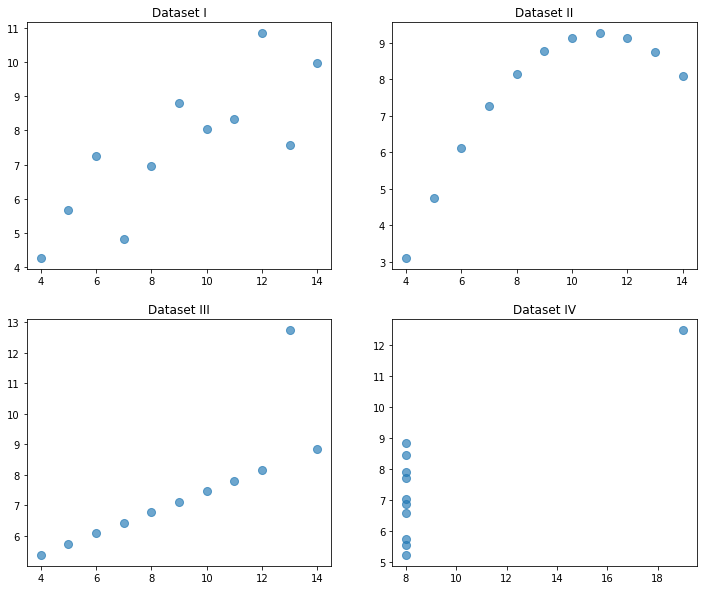

In [31]:
plt.figure(figsize=(12, 10))

for i, n in enumerate(['I', 'II', 'III', 'IV']):
    rows = anscombe[anscombe.get('dataset') == n]
    x = rows['x']
    y = rows['y']
    
    plt.subplot(2, 2, i+1)
    plt.scatter(x, y, label=f'Dataset {n}', alpha=0.65, s=65)
    plt.title(f'Dataset {n}');

What do all four of these datasets have in common?

In [32]:
for i, n in enumerate(['I', 'II', 'III', 'IV']):
    rows = anscombe[anscombe.get('dataset') == n]
    x = rows['x']
    y = rows['y']
    
    r = correlation(x, y)
    outstr = f'''
    <b>Dataset {n}</b><br>
    $\\bar x$: {np.round(np.mean(x), 2)}<br>
    $\\bar y$: {np.round(np.mean(y), 2)}<br>
    $\\sigma_x$: {np.round(np.std(x), 2)}<br>
    $\\sigma_y$: {np.round(np.std(y), 2)}<br>
    $r$: {np.round(r, 2)}
    '''
    display(HTML(outstr))

They all share the exact same mean and standard deviation of $x$ and $y$, and the same correlation coefficient $r$! This means they all have the same best linear prediction rule, under squared loss.

However, that linear prediction rule looks better for some datasets than it does for others:

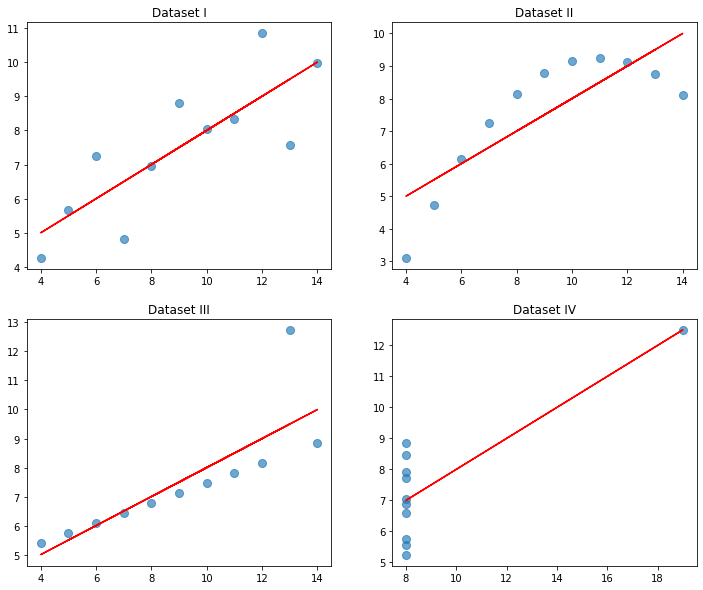

In [33]:
plt.figure(figsize=(12, 10))

for i, n in enumerate(['I', 'II', 'III', 'IV']):
    rows = anscombe[anscombe.get('dataset') == n]
    x = rows['x']
    y = rows['y']
    
    w0_ans = intercept(x, y)
    w1_ans = slope(x, y)
    
    plt.subplot(2, 2, i+1)
    plt.scatter(x, y, label=f'Dataset {n}', alpha=0.65, s=65)
    plt.plot(x, w0_ans + w1_ans * x, color='red');
    plt.title(f'Dataset {n}');

Moral of the story – visualize your data before trying to fit a prediction rule!

If that was interesting, [check out this article](https://www.autodesk.com/research/publications/same-stats-different-graphs).